ver3.  
변경사항: crawling 데이터 변경됨(news_df_210205_v03.xlsx → news_df_210222_v04.xlsx)  
기존 EDA 파일 정리사항(dropna, sort(date)) 여기에 반영  
적정 토픽수 도출 CoherenceModel 추가  

# Import

## Import library

In [1]:
import os
import sys
import warnings
from tqdm import tqdm, tqdm_notebook 
import pickle

import numpy as np
import pandas as pd
from tabulate import tabulate
from datetime import datetime 
from datetime import date, timedelta

# 데이터 전처리
import re
from konlpy.tag import Okt
from konlpy.tag import Mecab
import rhinoMorph

# 데이터 분석
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import gensim
from gensim import corpora
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from sklearn.decomposition import LatentDirichletAllocation

# 데이터 시각화
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='white', context='notebook', palette='deep')
# import pyLDAvis
import pyLDAvis.gensim
import pyLDAvis.sklearn

# 요약
from gensim.summarization.summarizer import summarize
import kss

warnings.filterwarnings(action='ignore')
warnings.filterwarnings("ignore", category=DeprecationWarning)

# function

In [2]:
def setDIR():
    # 현재 jupyter 위치를 PROJECT_DIR 추가
    PROJECT_DIR = os.path.abspath(os.path.join(os.path.realpath('__file__'), '..'))
    sys.path.insert(0, PROJECT_DIR)
    DATA_DIR = PROJECT_DIR + '/data' # 데이터 위치 
    print(DATA_DIR)
    
    return DATA_DIR

In [3]:
def cleaningData(data, drop_col_name, sort_col_name):
    '''
    데이터를 정제해주는 함수입니다. 
    1) 기준 column에 None이 존재하는 경우 drop을 진행하고, 정제를 합니다.
    2) 인덱스를 초기화해줍니다.
    
    Parameters: 
    ---------- 
    data : DataFrame
        정제 대상
    drop_col_name : str
        내용이 없는 경우 drop하고 정제할 column의 이름
    sort_col_name : str
        최종 DataFrame의 정렬 기준이 되는 column의 이름
    
    Returns: 
    ------- 
    df : DataFrame
        정제한 데이터
    '''
    df = data.copy()
    print(drop_col_name, '--- None 개수: ', df[drop_col_name].isna().sum())
    print('\n\n=== 제거 데이터 ===\n', tabulate(df.loc[data[drop_col_name].isna()]))
    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True) # drop 후 인덱스가 변경되지 않아 index reset 진행
    df[drop_col_name] = df[drop_col_name].apply(lambda x: re.sub(r'[^A-Za-z0-9가-힣 ]','',x.replace('.',' '))) # cleaning
    df.sort_values(by=[sort_col_name], inplace=True) # 정렬
    
    return df

In [4]:
def tokenizeData(text, stopwords, module, option=None):
    '''
    텍스트를 토큰화하고 불용어를 제거하여 문자길이가 2이상인 단어를 추출하는 함수입니다. 
    
    Parameters: 
    ---------- 
    text : str
        토큰화 대상
    stopwords : list[str,...,str]
        불용어 리스트
    module : str
        모듈 입력 가능 리스트 입니다.
        - 'okt.morphs', 'okt.morphs', 'okt.nouns', 'mecab.morphs', 'mecab.nouns', 'rhino'
    option : str, default = None
        okt.morphs에 옵션을 추가하는 경우로, 'stem' 또는 'norm'를 입력합니다.
        - stem: 각 단어 어간 추출, norm : 문장정규화
    
    Returns: 
    ------- 
    token : list[str,...,str]
         토큰화된 데이터
    '''

    r = re.compile("okt*")
    isOkt = False
    if r.search(module) is None:
        pass
    else:
        isOkt = True
        
    token = []
    if isOkt:
        okt = Okt()
        if module == 'okt.morphs':
            if option == None:
                token = okt.morphs(text)
            elif option == 'stem':
                token = okt.morphs(text, stem = True)
            elif option == 'norm':
                token = okt.morphs(text, norm = True)
        elif module == 'okt.nouns':
            token = okt.nouns(text)
    elif module == 'mecab.morphs':
        mecab = Mecab(dicpath=r"C:\mecab\mecab-ko-dic")
        token = mecab.morphs(text)
    elif module == 'mecab.nouns':
        mecab = Mecab(dicpath=r"C:\mecab\mecab-ko-dic")
        token = mecab.nouns(text)
    elif module == 'rhino':
        # 실질형태소, NNG: 일반명사 / NNP: 고유명사 / VA: 형용사
        rhino = rhinoMorph.startRhino()
        token = rhinoMorph.onlyMorph_list(rhino, text, pos=['NNG','NNP','VA'], combineN=True)
    
    if len(token) > 0:
        token = [word for word in token if word not in stopwords if len(word) > 1]
    
    return token

In [5]:
def display_voca_count(data_series, voca_num=30, figsize=(15,10)):
    '''
    토큰화된 데이터 컬럼의 단어를 카운트하여 출현 빈도수가 높은 순으로 bar 그래프로 보여주는 함수입니다. 
    
    Parameters: 
    ---------- 
    data_series : pandas Series
        토큰화된 데이터
    voca_num : int
        단어 수, default = 30
    figsize : (width, height)
        그래프 사이즈, default = (15,10)
        - 'okt.morphs', 'okt.morphs', 'okt.nouns', 'mecab.morphs', 'mecab.nouns', 'rhino'
    
    '''
    
    ds = data_series.copy()
    sorted_keys = ds.apply(lambda x : x[0]).tolist()
    sorted_values = ds.apply(lambda x : x[1]).tolist()

    plt.figure(figsize=figsize)
    plt.rc('font', family='NanumGothic') 
    plt.bar(range(voca_num), sorted_values[:voca_num], color='#9999ff')
    plt.xticks(range(voca_num), sorted_keys[:voca_num], rotation=45)
    plt.show()

In [6]:
def display_cosim(module, data_series, figsize=(15,10)):
    # fit
    bow = module.fit_transform(data_series.astype(str))
    print(module.__class__, ':', bow.shape)

    # cosine similarity
    cos_sim = cosine_similarity(bow,bow)
    print('cos_sim.shape:',cos_sim.shape)
    print('cos_sim:',cos_sim)
    plt.figure(figsize=figsize)
    sns.heatmap(cos_sim)

In [7]:
# 각 토픽별로 연관도가 높은 순으로 word 나열
def get_topics(model, feature_names, n=50):
    topic_list = []
    for topic_idx, topic in enumerate(model.components_):
        print('Topic #', topic_idx)  # topic num
        tlist = [(feature_names[i], topic[i].round(2)) for i in topic.argsort()[::-1][:n]] # topic 단어, 연관도
        print(tlist[:20])
        topic_list.append(tlist)

    return topic_list

In [8]:
def sklLDA(data, num_topics):
    # CountVectorizer : sklearn 제공
    # - max_df: 전체 문서에 걸쳐서 너무 높은 빈도수를 가지는 단어를 제외하기 위함 
    # - min_df: 전체 문서에 걸쳐서 너무 낮은 빈도수를 가지는 단어를 제외하기 위함
    # - max_features : 추출하는 feature의 개수 제한. 정수 지정
    cnt_vect = CountVectorizer(max_df=2000, lowercase=False, min_df=10, stop_words=stopwords)
    cnt_matrix = cnt_vect.fit_transform(data.apply(lambda x : ' '.join(w for w in x)))

    # LDA (LatentDirichletAllocation) : sklearn 제공
    # - n_components 파라미터를 이용해 이 토픽 개수를 조정함
    lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=0)
    lda_topic = lda_model.fit_transform(cnt_matrix)
    feature_names = cnt_vect.get_feature_names()
    print(lda_model.components_.shape)
#     print(lda_model.components_)
    topic_list = get_topics(lda_model, feature_names)
    
    return lda_model, cnt_matrix, cnt_vect, topic_list

In [9]:
# getTopicCount를 통해 문서 내 토픽 별 포함된 단어 숫자 count
# - doc: 1개의 문서, 단어로, list 타입
# - topic_list: 토픽 별로 단어가 list로 묶여 있는 list 타입
def getTopicCount(doc, topic_list):  
    cnt_per_topic=np.zeros(len(topic_list), dtype=int)
    for i,words in enumerate(topic_list):
        for word in words:
            if word in doc:
                cnt_per_topic[i] +=1
    return cnt_per_topic

In [10]:
# 토픽 별 단어 포함 수를 비교해 높은 값을 토픽 값으로 함
# - max : 제일 높은 토픽 번호, 포함 단어 수
# - second : 두번째로 높은 토픽 번호, 포함 단어 수
# - gap :  max와 second 차이
def getTopicDiff(doc, topic):
    cnt_per_topic = getTopicCount(doc, topic)
    x = {i: int(v) for i, v in enumerate(cnt_per_topic)} # type: dict, (topic num : count value)
    s = sorted(x.items(), key=lambda item: item[1], reverse=True) # sort : count value 기준으로 내림차순
    diff = {'max' : s[0], 'second' : s[1], 'gap' : s[0][1] - s[1][1] }
    if diff['gap'] == 0: # 앞쪽 토픽 쏠림 현상 방지
        diff['max'] = s[1]
        diff['second'] = s[0]

    return diff

In [11]:
def getTopicNum(doc, topic):
    diff = getTopicDiff(doc, topic)
    
    topic_num = -1
    if diff['gap'] > 0:
        topic_num = diff['max'][0]
    elif diff['gap'] == 0:  # 토픽이 중복되는 경우 제거하고자 -1로 반환하도록 함
        pass    
    
    return topic_num

In [12]:
# 현재 jupyter 위치를 PROJECT_DIR 추가
PROJECT_DIR = os.path.abspath(os.path.join(os.path.realpath('__file__'), '..'))
sys.path.insert(0, PROJECT_DIR)
DATA_DIR = PROJECT_DIR + '/data' # 데이터 위치 
print(DATA_DIR)

C:\Users\lime1\Documents\study\Python\project/data


# main

## import

In [13]:
DATA_DIR = setDIR()

C:\Users\lime1\Documents\study\Python\project/data


In [14]:
data = pd.read_excel(DATA_DIR +'/news_df_210222_v05.xlsx')
data.info()
data.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 861 entries, 0 to 860
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   media             861 non-null    object
 1   date              861 non-null    object
 2   title             861 non-null    object
 3   article_original  853 non-null    object
 4   url               861 non-null    object
dtypes: object(5)
memory usage: 33.8+ KB


,media,date,title,article_original,url
0,조선일보,2020-01-02,150만명 몰린 타임스스퀘어 새해 무대도 BTS,2012년 싸이에 이어 두 번째 ABC방송 라이브 쇼에서 생중계 전 지구를 홀린 ...,https://news.naver.com/main/read.nhn?mode=LSD&...
1,조선일보,2020-01-02,방탄소년단 CNN 선정 2010년대 음악 변화시킨 아티스트,방탄소년단BTS이 미국 CNN 선정 2010년대 음악을 변화시킨 10대 아티스트에...,https://news.naver.com/main/read.nhn?mode=LSD&...


# 데이터 전처리

## 사용 데이터 정리
기사 본문이 존재하지 않는 8개의 기사는 삭제하고자 합니다.

In [15]:
data_df = cleaningData(data, drop_col_name = 'article_original', sort_col_name = 'date')

article_original --- None 개수:  8


=== 제거 데이터 ===
 ---  --------  ----------  -----------------------------------------------------------------------------------------------------------------------  ---  -------------------------------------------------------------------------------------
157  중앙일보  2020-03-22  민기자야 BTS 기사 쓴 기자가 직접 자기 기사 댓글 읽었다                                                                   nan  https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=103&oid=025&aid=0002986222
211  조선일보  2020-05-15  사진 BTS RM이 남긴 미술관 방명록쉽지 않은 시기 같이 이겨내요                                                             nan  https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=103&oid=023&aid=0003531504
405  한겨레    2020-09-02  영상 BTS 빌보드 핫 100 1위온라인 글로벌 기자간담회                                                                       nan  https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=103&oid=028&aid=0002511264
407  경향신문  2020-09-02  BTS Makes It over the Final Billboard Thres

In [16]:
# 전처리 확인
idx = 8
print('--- cleaning 전 ---\n', data['article_original'].iloc[idx], '\n\n')
print('--- cleaning 후 ---\n', data_df['article_original'].iloc[idx], '\n\n')
data_df.info()

--- cleaning 전 ---
  그룹 방탄소년단BTS이 다음 달 21일 새 앨범으로 돌아온다. 소속사 빅히트엔터테인먼트는 8일 오전 0시 팬 커뮤니티 BTS 위버스 공지를 통해 오는 2월 21일 BTS 맵 오브 더 솔 7MAP OF THE SOUL 7이 발매된다고 밝혔다. 예약판매는 오는 9일부터 진행된다. 앞서 지난해 말 방탄소년단 리더 RM은 미국 연예매체 버라이어티 주최 시상식에서 좋은 소식은 우리가 새로운 음악 새로운 앨범을 작업하고 있다는 것이라며 가까운 미래에 여러분과 이를 공유할 수 있을 것으로 기대한다고 말한 바 있다. 방탄소년단의 새 앨범은 지난해 4월 맵 오브 더 솔 연작의 첫 앨범인 맵 오브 더 솔 페르소나MAP OF THE SOUL PERSONA 이후 약 10개월 만이다. 전작 맵 오브 더 솔 페르소나는 369만장의 판매고를 올리며 가온차트가 2011년 집계를 시작한 이래 최다 판매량을 기록했다. 빌보드 메인 앨범 차트인 빌보드 200 정상에도 오르며 국외에서도 각종 굵직한 기록을 남겼다. 


--- cleaning 후 ---
  그룹 방탄소년단BTS이 다음 달 21일 새 앨범으로 돌아온다  소속사 빅히트엔터테인먼트는 8일 오전 0시 팬 커뮤니티 BTS 위버스 공지를 통해 오는 2월 21일 BTS 맵 오브 더 솔 7MAP OF THE SOUL 7이 발매된다고 밝혔다  예약판매는 오는 9일부터 진행된다  앞서 지난해 말 방탄소년단 리더 RM은 미국 연예매체 버라이어티 주최 시상식에서 좋은 소식은 우리가 새로운 음악 새로운 앨범을 작업하고 있다는 것이라며 가까운 미래에 여러분과 이를 공유할 수 있을 것으로 기대한다고 말한 바 있다  방탄소년단의 새 앨범은 지난해 4월 맵 오브 더 솔 연작의 첫 앨범인 맵 오브 더 솔 페르소나MAP OF THE SOUL PERSONA 이후 약 10개월 만이다  전작 맵 오브 더 솔 페르소나는 369만장의 판매고를 올리며 가온차트가 2011년 집계를 시작한 이래 최다 판매량을 기록했다  빌보드 메인 앨범 

# 단어 토큰화

아래 토큰화 시 불용어를 삭제하기 위해 stop word를 파일을 불러옵니다.   
stop word 출처: https://www.ranks.nl/stopwords/korean  

In [17]:
stopwords = open(DATA_DIR+'/stopwords.txt','r', encoding='utf-8').read().split('\n')
stopwords[:10]

['아', '휴', '아이구', '아이쿠', '아이고', '어', '나', '우리', '저희', '따라']

rhinoMorph 패키지를 사용하며, 불용어와 1글자 이하는 제거합니다.  
※ 주의: konlpy 패키지와 rhinoMorph 패키지를 함께 실행하면 에러가 발생합니다.

In [18]:
# rhino
# 실질형태소, 어말어미(emoi) 제외
# NNG: 일반명사 / NNP: 고유명사 / VA: 형용사 
tqdm.pandas()
rhino = rhinoMorph.startRhino()
data_df['token_rhino'] = data_df.article_original.progress_apply(lambda x: rhinoMorph.onlyMorph_list(rhino, x, pos=['NNG','NNP','VA'], combineN=True))
data_df.token_rhino = data_df.token_rhino.apply(lambda x : [w for w in x if x not in stopwords if len(w) >1])  # 불용어 제거

data_df.head(2)

filepath:  C:\Users\lime1\anaconda3\Lib\site-packages
classpath:  C:\Users\lime1\anaconda3\Lib\site-packages\rhinoMorph/lib/rhino.jar


  0%|                                                                                          | 0/853 [00:00<?, ?it/s]

RHINO started!


100%|████████████████████████████████████████████████████████████████████████████████| 853/853 [00:24<00:00, 34.41it/s]


,media,date,title,article_original,url,token_rhino
0,조선일보,2020-01-02,150만명 몰린 타임스스퀘어 새해 무대도 BTS,2012년 싸이에 이어 두 번째 ABC방송 라이브 쇼에서 생중계 전 지구를 홀린 ...,https://news.naver.com/main/read.nhn?mode=LSD&...,"[방송, 라이브, 생중계, 지구, 그룹, 사회자, 소개, 방탄, 모습, 마지막, 미..."
1,조선일보,2020-01-02,방탄소년단 CNN 선정 2010년대 음악 변화시킨 아티스트,방탄소년단BTS이 미국 CNN 선정 2010년대 음악을 변화시킨 10대 아티스트에...,https://news.naver.com/main/read.nhn?mode=LSD&...,"[방탄, 미국, 선정, 음악, 변화, 아티스트, 자신, 음악, 장르, 스스로, 재창..."


In [19]:
idx = 8
print('\n === ', idx, ' ===\n')
print('\n-- article_original --\n', data_df['article_original'].iloc[idx])
print('\n-- rhinoMorph --\n', data_df['token_rhino'].iloc[idx])


 ===  8  ===


-- article_original --
  그룹 방탄소년단BTS이 다음 달 21일 새 앨범으로 돌아온다  소속사 빅히트엔터테인먼트는 8일 오전 0시 팬 커뮤니티 BTS 위버스 공지를 통해 오는 2월 21일 BTS 맵 오브 더 솔 7MAP OF THE SOUL 7이 발매된다고 밝혔다  예약판매는 오는 9일부터 진행된다  앞서 지난해 말 방탄소년단 리더 RM은 미국 연예매체 버라이어티 주최 시상식에서 좋은 소식은 우리가 새로운 음악 새로운 앨범을 작업하고 있다는 것이라며 가까운 미래에 여러분과 이를 공유할 수 있을 것으로 기대한다고 말한 바 있다  방탄소년단의 새 앨범은 지난해 4월 맵 오브 더 솔 연작의 첫 앨범인 맵 오브 더 솔 페르소나MAP OF THE SOUL PERSONA 이후 약 10개월 만이다  전작 맵 오브 더 솔 페르소나는 369만장의 판매고를 올리며 가온차트가 2011년 집계를 시작한 이래 최다 판매량을 기록했다  빌보드 메인 앨범 차트인 빌보드 200 정상에도 오르며 국외에서도 각종 굵직한 기록을 남겼다 

-- rhinoMorph --
 ['그룹', '방탄', '다음', '앨범', '소속사', '빅히트엔터테인먼트', '오전', '커뮤니티', '공지', '오브', '예약판매', '지난해', '방탄소년단', '리더', '미국', '연예매체', '버라이어티', '주최', '시상식', '소식', '새롭', '음악', '새롭', '앨범', '가깝', '미래', '방탄소년단', '앨범', '지난해', '오브', '연작', '앨범', '오브', '이후', '전작', '오브', '페르소나', '판매고', '가온차트', '집계', '시작', '최다', '판매량', '빌보드', '메인', '앨범', '차트', '빌보드', '정상', '국외', '각종', '기록']


# 단어 분포 확인

['방송', '라이브', '생중계', '지구', '그룹', '사회자', '소개', '방탄', '모습', '마지막', '미국', '뉴욕', '맨해튼', '타임스스퀘어', '무대', '현지', '시각', '저녁', '타임스스퀘어', '드롭대형']


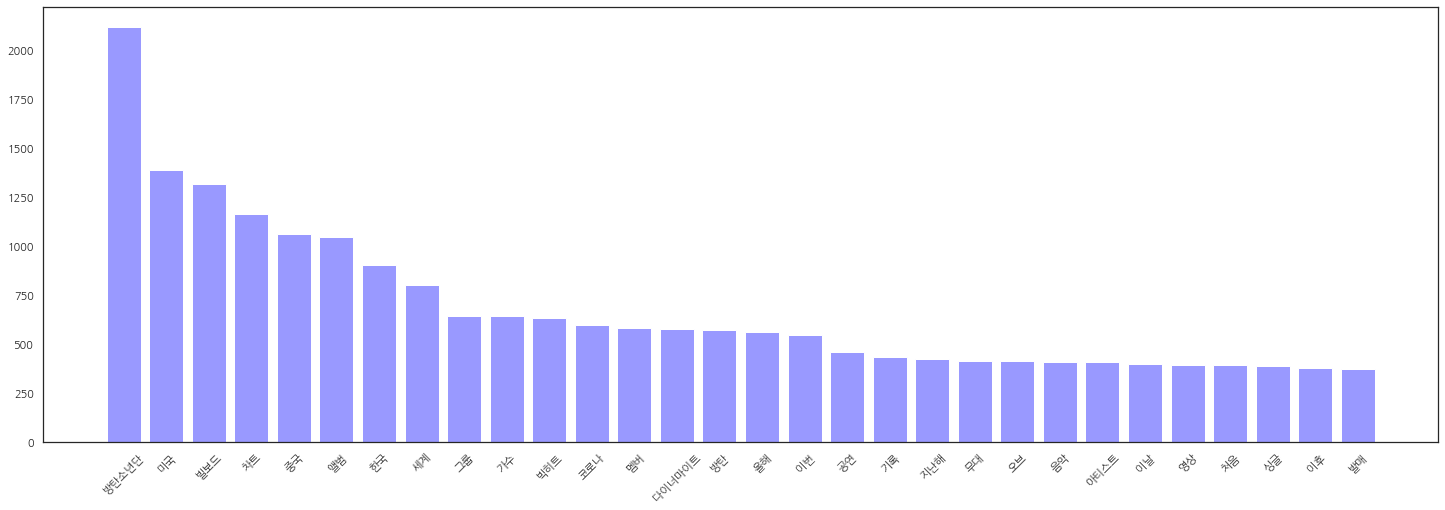

In [20]:
# rhino
words_list = [word for sent in data_df['token_rhino'] for word in sent]
print(words_list[:20])
vocab = Counter(words_list)
display_voca_count(pd.Series(vocab.most_common(100)), voca_num=30, figsize=(25,8))

# 문서유사도

문서유사도를 확인하기 위해 article original과 rhinoMorph를 활용해 토큰화한 단어를 CountVectorizer와 TfidifVectorizer를 활용하여 BoW를 만들고자 한다.  
이후 이를 통해 Cosine similarity를 확인하고자 한다.  



--- cosine similarity CountVectorizer ( rhinoMorph ) ---
<class 'sklearn.feature_extraction.text.CountVectorizer'> : (853, 1567)
cos_sim.shape: (853, 853)
cos_sim: [[1.         0.25954955 0.24509473 ... 0.29599735 0.03942083 0.17418432]
 [0.25954955 1.         0.33318039 ... 0.21448551 0.01075829 0.16997871]
 [0.24509473 0.33318039 1.         ... 0.14343096 0.02606873 0.27226002]
 ...
 [0.29599735 0.21448551 0.14343096 ... 1.         0.09709467 0.21282531]
 [0.03942083 0.01075829 0.02606873 ... 0.09709467 1.         0.09298372]
 [0.17418432 0.16997871 0.27226002 ... 0.21282531 0.09298372 1.        ]]


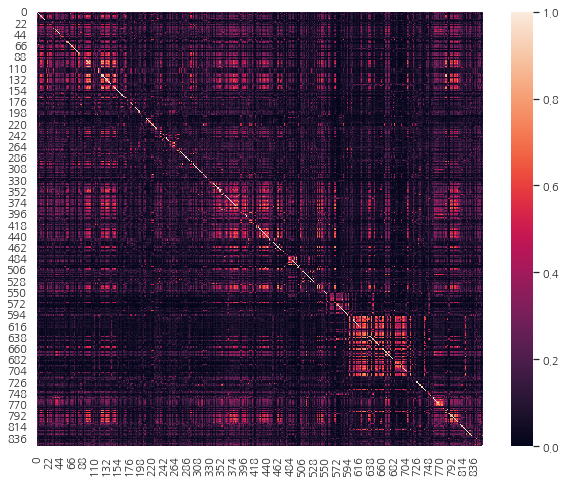

In [21]:
# CountVectorizer : sklearn 제공
# - max_df: 전체 문서에 걸쳐서 너무 높은 빈도수를 가지는 단어를 제외하기 위함 
# - min_df: 전체 문서에 걸쳐서 너무 낮은 빈도수를 가지는 단어를 제외하기 위함
# - max_features : 추출하는 feature의 개수 제한. 정수 지정
cnt_vect = CountVectorizer(max_df=2000, lowercase=False, min_df=10, stop_words=stopwords)
# # fit CountVectorizer - rhinoMorph
print('\n\n--- cosine similarity CountVectorizer ( rhinoMorph ) ---')
display_cosim(cnt_vect, data_df.token_rhino, figsize=(10,8))



--- cosine similarity TfidfVectorizer ( rhinoMorph ) ---
<class 'sklearn.feature_extraction.text.TfidfVectorizer'> : (853, 2213)
cos_sim.shape: (853, 853)
cos_sim: [[1.         0.17226535 0.15075869 ... 0.18259783 0.01712649 0.06649991]
 [0.17226535 1.         0.12111563 ... 0.09505775 0.0018393  0.09050406]
 [0.15075869 0.12111563 1.         ... 0.07660435 0.01752608 0.17299849]
 ...
 [0.18259783 0.09505775 0.07660435 ... 1.         0.05269303 0.09245597]
 [0.01712649 0.0018393  0.01752608 ... 0.05269303 1.         0.05677021]
 [0.06649991 0.09050406 0.17299849 ... 0.09245597 0.05677021 1.        ]]


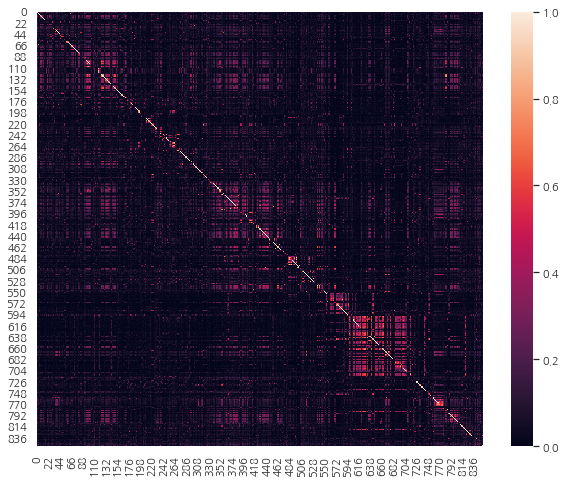

In [22]:
# TfidfVectorizer
# - tokenizer = LemNormalize 표준화, 사전(dic)에 기반한 표준화 
tfidf_vect = TfidfVectorizer(stop_words=stopwords, ngram_range=(1,2), min_df=10, max_df=2000)

# # cosine similarity - rhinoMorph (TfidfVectorizer)
print('\n\n--- cosine similarity TfidfVectorizer ( rhinoMorph ) ---')
display_cosim(tfidf_vect, data_df.token_rhino, figsize=(10,8))

article_original 문서보다는 rhinoMorph로 토큰화된 문서가 문서유사도를 보다 선명하게 나타납니다.  
또한 TfidfVecotrizer가 CountVectorizer보다 문서유사도로 관계성 높은 그룹을 잘 나타내는 것으로 관찰됩니다.

# 토픽 모델링(LDA)으로 그룹화
- Latent Dirichlet Allocation
- 단어가 특정 토픽에 존재할 확률과 문서에 특정 토픽이 존재할 확률을 결합할 확률로 추정하여 토픽 추출하는 방법입니다.  
- 문서들이 토픽들의 혼합으로 구성되어져 있으며, 토픽들은 확률분포에 기반하여 단어를 생성한다고 가정합니다.  

<br></br>

- 사용자 알고리즘 지정사항: 토픽 개수
- 모든 문서의 모든 단어에 대하여 아래 사항 반복 진행
    - 어떤 문서의 각 단어 w는 자신은 잘못된 토픽에 할당되어져 있지만, 다른 단어들은 전부 올바른 토픽에 할당되어져 있는 상태라고 가정.
    - 이에 따라 단어 w는 아래 두가지 기준에 따라 토픽 재할당
        - 문서 d의 단어들 중 토픽 t에 해당하는 단어 비율
        - 단어 w를 갖고 있는 모든 문서들 중 토픽 t가 할당된 비율

## 적정 토픽 수 추정

###  sklearn LDA - CoutVectorizer

In [23]:
# 토픽 개수: 6
TOPICS_NUM = 6
lda_model, cnt_matrix, cnt_vect, topic_list = sklLDA(data_df.token_rhino, TOPICS_NUM)

# LDA 시각화하기  
# - 각 원과의 거리는 각 토픽들이 서로 얼마나 다른지를 보여줍니다. 
# - 만약 두 개의 원이 겹친다면, 이 두 개의 토픽은 유사한 토픽이라는 의미입니다. 
# pyLDAvis.sklearn.prepare(lda_model, dtm_matrix, vectorizer)
# - lda_model = calculated topic model
# - dtm_matrix = document word frequency matrix
# - vectorizer = word space

pyLDAvis.enable_notebook()
vis = pyLDAvis.sklearn.prepare(lda_model, cnt_matrix, cnt_vect)

# Visualization can be displayed in the notebook  
pyLDAvis.display(vis)

(6, 1567)
Topic # 0
[('빌보드', 1184.56), ('차트', 1154.91), ('앨범', 995.26), ('방탄소년단', 971.35), ('미국', 726.77), ('다이너마이트', 502.68), ('가수', 407.05), ('기록', 389.53), ('싱글', 360.81), ('발매', 355.11), ('그룹', 320.71), ('오브', 304.92), ('한국', 303.15), ('정상', 297.06), ('판매량', 263.79), ('세계', 257.97), ('처음', 231.23), ('스트리밍', 224.01), ('순위', 219.11), ('연속', 215.21)]
Topic # 1
[('병역', 211.12), ('대통령', 155.4), ('의원', 140.38), ('문제', 121.69), ('분야', 109.86), ('연기', 109.45), ('병역특례', 108.17), ('장관', 104.54), ('병역법', 85.17), ('한류', 76.57), ('국민', 74.32), ('국회', 70.86), ('정치', 69.28), ('특례', 69.17), ('정부', 66.11), ('최고위원', 64.17), ('개정안', 61.17), ('이날', 60.33), ('공정', 59.27), ('더불어민주당', 57.17)]
Topic # 2
[('빅히트', 554.31), ('청년', 214.76), ('방탄소년단', 183.32), ('시장', 169.4), ('대표', 168.0), ('상장', 157.58), ('멤버', 143.47), ('지난해', 133.11), ('매출', 132.84), ('엔터테인먼트', 125.08), ('브랜드', 123.61), ('국내', 119.83), ('패션', 110.86), ('공모', 105.17), ('회사', 103.34), ('광고', 97.82), ('기준', 97.46), ('인기', 95.69), ('글로벌', 95.11

In [24]:
pd.DataFrame(topic_list).T

,0,1,2,3,4,5
0,"(빌보드, 1184.56)","(병역, 211.12)","(빅히트, 554.31)","(중국, 1047.15)","(방탄소년단, 633.29)","(공연, 396.73)"
1,"(차트, 1154.91)","(대통령, 155.4)","(청년, 214.76)","(한국, 284.99)","(후보, 311.86)","(콘서트, 274.68)"
2,"(앨범, 995.26)","(의원, 140.38)","(방탄소년단, 183.32)","(미국, 229.38)","(멤버, 284.16)","(방탄소년단, 218.17)"
3,"(방탄소년단, 971.35)","(문제, 121.69)","(시장, 169.4)","(네티즌, 203.17)","(올해, 281.31)","(코로나, 211.9)"
4,"(미국, 726.77)","(분야, 109.86)","(대표, 168.0)","(관련, 198.47)","(미국, 277.38)","(세계, 201.38)"
5,"(다이너마이트, 502.68)","(연기, 109.45)","(상장, 157.58)","(발언, 167.44)","(무대, 274.48)","(작가, 135.16)"
6,"(가수, 407.05)","(병역특례, 108.17)","(멤버, 143.47)","(논란, 160.05)","(시상식, 237.91)","(서울, 130.27)"
7,"(기록, 389.53)","(장관, 104.54)","(지난해, 133.11)","(역사, 158.16)","(부문, 233.94)","(온라인, 124.61)"
8,"(싱글, 360.81)","(병역법, 85.17)","(매출, 132.84)","(한국전쟁, 150.17)","(영상, 227.66)","(작품, 113.87)"
9,"(발매, 355.11)","(한류, 76.57)","(엔터테인먼트, 125.08)","(전쟁, 133.49)","(코로나, 201.01)","(한국, 105.26)"


In [25]:
# word_set : topic 별 단어만 set 형태로 저장
word_set = [ {w[0] for w in t} for t in topic_list ] 
# print(word_set)

# compare : 하나의 토픽과 나머지 토픽과 중복되는 단어 추출
inter_list = []
for i in range(len(word_set)):
    intersect_vocab = set()
    for j, s in enumerate(word_set):
        if i == j:
            continue
        else:
            intersect_vocab.update(word_set[i] & s)
    inter_list.append(intersect_vocab)

# 토픽 별 유일한 단어만 남기기
unique_twords= [word_set[i] - inter_list[i] for i in range(len(word_set))]
pd.DataFrame(unique_twords).T

# 토픽 단어 별 유사도, 빈도 보이기
unique_sort_twords = []
for i, t in enumerate(topic_list):
    tmp = [ w for w in t if w[0] in unique_twords[i] ]
    unique_sort_twords.append(tmp)

# pd.DataFrame(unique_sort_twords).T

# # 중복 제거 후 토픽 별로 None 없이 모두 값이 있는 경우로 토픽 단어 정리
new_topic_df = pd.DataFrame(unique_sort_twords).T.iloc[:min(map(len,unique_sort_twords))]
new_topic_df

,0,1,2,3,4,5
0,"(차트, 1154.91)","(병역, 211.12)","(시장, 169.4)","(중국, 1047.15)","(후보, 311.86)","(공연, 396.73)"
1,"(앨범, 995.26)","(대통령, 155.4)","(상장, 157.58)","(네티즌, 203.17)","(시상식, 237.91)","(콘서트, 274.68)"
2,"(기록, 389.53)","(의원, 140.38)","(매출, 132.84)","(발언, 167.44)","(부문, 233.94)","(작가, 135.16)"
3,"(싱글, 360.81)","(분야, 109.86)","(엔터테인먼트, 125.08)","(역사, 158.16)","(베스트, 184.25)","(작품, 113.87)"
4,"(발매, 355.11)","(연기, 109.45)","(브랜드, 123.61)","(한국전쟁, 150.17)","(메시지, 170.94)","(투어, 102.26)"
5,"(정상, 297.06)","(병역특례, 108.17)","(국내, 119.83)","(전쟁, 133.49)","(워즈, 162.6)","(예정, 101.28)"
6,"(판매량, 263.79)","(장관, 104.54)","(패션, 110.86)","(소감, 128.87)","(사람, 155.71)","(미술, 93.16)"
7,"(스트리밍, 224.01)","(병역법, 85.17)","(공모, 105.17)","(희생, 124.17)","(뮤직, 149.24)","(전시, 92.77)"
8,"(순위, 219.11)","(한류, 76.57)","(회사, 103.34)","(환구시보, 110.17)","(마음, 135.26)","(아미, 84.92)"
9,"(연속, 215.21)","(국민, 74.32)","(광고, 97.82)","(한미, 97.17)","(모습, 106.01)","(라이브, 76.27)"


In [26]:
unique_topic_list = new_topic_df.T.values.tolist()
unique_tword_list = [[wrd_cnt[0] for wrd_cnt in list_] for list_ in unique_topic_list]
print(unique_tword_list[0][:10])

checkTopic = pd.DataFrame(data=None, columns={'topic_count','topic_diff','topic_num'})
checkTopic['topic_count'] = data_df.token_rhino.apply(lambda x: getTopicCount(x, unique_tword_list))
checkTopic['topic_diff'] = data_df.token_rhino.apply(lambda x: getTopicDiff(x, unique_tword_list))
checkTopic['topic_num'] = data_df.token_rhino.apply(lambda x: getTopicNum(x, unique_tword_list))
checkTopic

['차트', '앨범', '기록', '싱글', '발매', '정상', '판매량', '스트리밍', '순위', '연속']


,topic_diff,topic_count,topic_num
0,"{'max': (5, 2), 'second': (4, 2), 'gap': 0}","[1, 0, 1, 0, 2, 2]",-1
1,"{'max': (0, 4), 'second': (2, 2), 'gap': 2}","[4, 0, 2, 0, 1, 1]",0
2,"{'max': (5, 9), 'second': (0, 3), 'gap': 6}","[3, 0, 3, 0, 0, 9]",5
3,"{'max': (5, 4), 'second': (4, 2), 'gap': 2}","[1, 0, 1, 0, 2, 4]",5
4,"{'max': (4, 3), 'second': (1, 1), 'gap': 2}","[0, 1, 1, 1, 3, 0]",4
...,...,...,...
848,"{'max': (4, 9), 'second': (0, 7), 'gap': 2}","[7, 1, 2, 6, 9, 7]",4
849,"{'max': (0, 5), 'second': (5, 2), 'gap': 3}","[5, 0, 0, 1, 1, 2]",0
850,"{'max': (4, 8), 'second': (0, 8), 'gap': 0}","[8, 5, 3, 5, 8, 8]",-1
851,"{'max': (5, 2), 'second': (1, 2), 'gap': 0}","[1, 2, 1, 0, 0, 2]",-1


In [27]:
checkTopic.groupby(by='topic_num')['topic_count'].count()

topic_num
-1     87
 0    265
 1     65
 2    112
 3     94
 4    124
 5    106
Name: topic_count, dtype: int64

In [28]:
checkTopic[checkTopic['topic_num']==-1]

,topic_diff,topic_count,topic_num
0,"{'max': (5, 2), 'second': (4, 2), 'gap': 0}","[1, 0, 1, 0, 2, 2]",-1
6,"{'max': (4, 1), 'second': (2, 1), 'gap': 0}","[0, 0, 1, 0, 1, 0]",-1
40,"{'max': (4, 4), 'second': (0, 4), 'gap': 0}","[4, 0, 0, 1, 4, 2]",-1
51,"{'max': (4, 3), 'second': (0, 3), 'gap': 0}","[3, 0, 0, 2, 3, 3]",-1
68,"{'max': (5, 3), 'second': (2, 3), 'gap': 0}","[1, 1, 3, 0, 0, 3]",-1
...,...,...,...
835,"{'max': (5, 5), 'second': (4, 5), 'gap': 0}","[0, 0, 3, 0, 5, 5]",-1
837,"{'max': (3, 7), 'second': (2, 7), 'gap': 0}","[5, 2, 7, 7, 4, 6]",-1
840,"{'max': (2, 4), 'second': (1, 4), 'gap': 0}","[2, 4, 4, 3, 1, 2]",-1
850,"{'max': (4, 8), 'second': (0, 8), 'gap': 0}","[8, 5, 3, 5, 8, 8]",-1


In [29]:
data_df['topic_num'] = data_df['token_rhino'].apply(lambda x : getTopicNum(x, unique_tword_list))
data_df.head()

,media,date,title,article_original,url,token_rhino,topic_num
0,조선일보,2020-01-02,150만명 몰린 타임스스퀘어 새해 무대도 BTS,2012년 싸이에 이어 두 번째 ABC방송 라이브 쇼에서 생중계 전 지구를 홀린 ...,https://news.naver.com/main/read.nhn?mode=LSD&...,"[방송, 라이브, 생중계, 지구, 그룹, 사회자, 소개, 방탄, 모습, 마지막, 미...",-1
1,조선일보,2020-01-02,방탄소년단 CNN 선정 2010년대 음악 변화시킨 아티스트,방탄소년단BTS이 미국 CNN 선정 2010년대 음악을 변화시킨 10대 아티스트에...,https://news.naver.com/main/read.nhn?mode=LSD&...,"[방탄, 미국, 선정, 음악, 변화, 아티스트, 자신, 음악, 장르, 스스로, 재창...",0
2,조선일보,2020-01-03,방탄소년단 새앨범 작업중 새해도 K팝 인베이전 이어진다,트와이스 도쿄돔 공연 블랙핑크도 새앨범 예정 경자년 새해에도 K팝 스타들의 세계...,https://news.naver.com/main/read.nhn?mode=LSD&...,"[트와이스, 도쿄돔, 공연, 블랙핑크, 앨범, 예정, 경자, 새해, 스타, 세계, ...",5
3,조선일보,2020-01-03,서울시 BTS트와이스 활용해 K팝 관광명소 추천,K팝에 대한 관심이 전 세계적으로 높아지면서 서울시가 이른바 K팝 명소들을 선정해...,https://news.naver.com/main/read.nhn?mode=LSD&...,"[관심, 세계적, 서울시, 명소, 한국, 외국인, 관광객, 트와이스, 스타, 흔적,...",5
4,조선일보,2020-01-06,봉준호 BTS 영향력은 나의 3천배 멋진 아티스트의 나라,골든글로브 시상식에서 한국 최초로 외국어영화상을 수상한 기생충의 봉준호 감독이 한...,https://news.naver.com/main/read.nhn?mode=LSD&...,"[골든글로브, 시상식, 한국, 최초, 외국어영화상, 수상, 기생충, 봉준호, 감독,...",4


In [30]:
data_df.groupby(by='topic_num')['title'].count()

topic_num
-1     87
 0    265
 1     65
 2    112
 3     94
 4    124
 5    106
Name: title, dtype: int64

In [31]:
# data_df.drop(data_df[data_df['topic_num']==-1].index).groupby(by='topic_num')['title'].count()
data_df.drop(data_df[data_df['topic_num']==-1].index, inplace=True)
data_df.reset_index(drop=True, inplace=True)

In [32]:
data_df.groupby(by='topic_num')['title'].count()

topic_num
0    265
1     65
2    112
3     94
4    124
5    106
Name: title, dtype: int64

In [33]:
print(data_df.info())
data_df.tail(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 766 entries, 0 to 765
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   media             766 non-null    object
 1   date              766 non-null    object
 2   title             766 non-null    object
 3   article_original  766 non-null    object
 4   url               766 non-null    object
 5   token_rhino       766 non-null    object
 6   topic_num         766 non-null    int64 
dtypes: int64(1), object(6)
memory usage: 42.0+ KB
None


,media,date,title,article_original,url,token_rhino,topic_num
764,한겨레,2020-12-26,세계의 모든 힘없는 자들에게 2020 BTS 혁명,이 세계의 모든 힘없는 자들아 우리가 패배할 날이 올지도 모르지만 오늘은 아니야 ...,https://news.naver.com/main/read.nhn?mode=LSD&...,"[세계, 힘없, 오늘, 오늘, 투데이, 가운데, 방탄, 자체, 혁명, 지난달, 발표...",0
765,한겨레,2020-12-30,압도적 1위 BTS 916만장코로나에는 음반인 가요,코로나19 팬데믹으로 콘서트와 각종 음악 축제가 줄줄이 취소되는 등 올 한해 가요...,https://news.naver.com/main/read.nhn?mode=LSD&...,"[코로나, 콘서트, 각종, 음악, 축제, 한해, 가요, 직격탄, 음반, 시장, 폭발...",0


In [34]:
# datetime.datetime.strptime('2018-05-19', '%Y-%m-%d')
data_df['date'] = data_df['date'].apply(lambda x : datetime.strptime(x,'%Y-%m-%d'))

Text(0, 0.5, 'topic number')

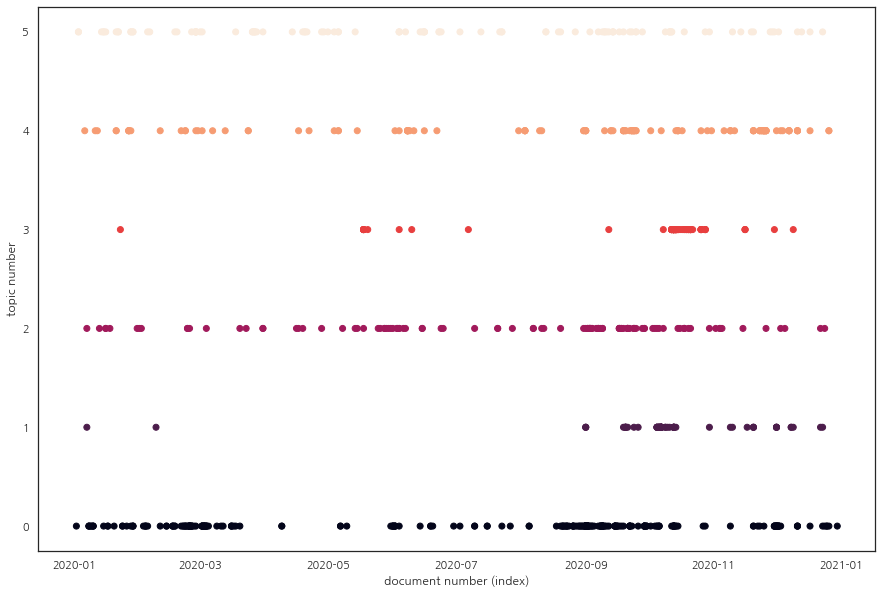

In [35]:
plt.figure(figsize=(15,10))
plt.scatter(x=data_df.date, y=data_df['topic_num'], c=data_df['topic_num'] )
plt.xlabel('document number (index)')
plt.ylabel('topic number')

In [36]:
# 각 토픽 별 해당하는 문서 번호(index) 삽입
num_topics = len(data_df.topic_num.unique())
topic_per_idx = [[] for i in range(num_topics)]
for i, topic_num in enumerate(data_df['topic_num']):
#     print(i,',',topic_num)
    topic_per_idx[topic_num].append(i)
#     print(topic_per_idx)

# 확인
for i, topic_idxs in enumerate(topic_per_idx):
    print(i, ':', len(topic_idxs))

0 : 265
1 : 65
2 : 112
3 : 94
4 : 124
5 : 106


In [37]:
# topic_div_idx : 토픽 별 월별 기사 인덱스 모음
MONTHS = 12 # 12개월
topic_month_idxs = [ [[] for i in range(MONTHS)] for j in range(len(topic_per_idx)) ]
# print(topic_div_idx)
for topic_num,idx_list in enumerate(topic_per_idx):
#     print(topic_num, ',', idx_list)
    for idx in idx_list:
        month = data_df['date'].iloc[idx].month-1
        topic_month_idxs[topic_num][month].append(idx)

# topic_div_idx 확인
# for i in topic_month_idxs:
#     print(i)

In [38]:
# 월별 기사의 양 확인
topic_mIdxs_cnt = [[[] for m in range(MONTHS)] for tnum in range(len(topic_month_idxs))]
for topic_num, idx_lists in enumerate(topic_month_idxs):
    for month, idx_list in enumerate(idx_lists):
        topic_mIdxs_cnt[topic_num][month] = (month,len(idx_list))
#     print(topic_mIdxs_cnt[topic_num])
# topic_mIdxs_cnt

In [39]:
# 토픽 내 상위 1~2 개월 구간 추출 
# - 조건: 토픽 내 문서 갯수 평균(m)보다 많고, 10개보다 큰 경우

topic_top_idxs = []

for idxlist in topic_mIdxs_cnt:
#     print(idxlist)
    srt_idxlist = sorted(idxlist, key= lambda x: x[1], reverse=True)
#     print(srt_idxlist)
    mean_idxlist = np.mean([x for _, x in srt_idxlist], dtype=int)
#     print(mean_idxlist)
    
    top_idxs = []
    for month, cnt in srt_idxlist:
#         print(month, ',', cnt)
        if (cnt > mean_idxlist) and (cnt>10):
            top_idxs.append((month, cnt))
    topic_top_idxs.append(top_idxs)
#     print(top_idxs,'\n')

topic_top_idxs


[[(8, 78), (1, 35), (2, 25), (7, 25), (11, 24)],
 [(9, 36), (8, 12)],
 [(8, 37), (9, 13), (4, 11), (5, 11)],
 [(9, 77)],
 [(10, 26), (8, 25), (11, 14), (5, 13)],
 [(8, 17), (0, 13), (5, 12), (1, 11)]]

In [60]:
# 토픽 별 유사 기간의 문서를 묶어줌

topic_period_idxs = [[] for i in range(len(topic_month_idxs))]

for topic_num, top_idxs in enumerate(topic_top_idxs):
    top_idxs = sorted(top_idxs, key= lambda x: x[0])
    print(topic_num,':', top_idxs)
    for month, cnt in top_idxs:
        print('-- month:',month,', cnt:', cnt)
        print(topic_month_idxs[topic_num][month])
        set_idxs = set(topic_month_idxs[topic_num][month])
        # 현재 month의 시작과 끝 index
        curr_1stD_idx = topic_month_idxs[topic_num][month][0]
#         print('curr_1stD_idx:', curr_1stD_idx)
        curr_lastD_idx = topic_month_idxs[topic_num][month][-1]
#         print('curr_lastD_idx:',curr_lastD_idx)
        
        # 이전 구간의 마지막 문서의 날짜와 기간 간격 비교
        if (month>0) and (topic_mIdxs_cnt[topic_num][month-1][1]>0) :
            pre_lastD_idx = topic_month_idxs[topic_num][month-1][-1]
#             print('pre_lastD_idx:',pre_lastD_idx)
        
            if timedelta(3) >= (data_df['date'].iloc[curr_1stD_idx]- data_df['date'].iloc[pre_lastD_idx]):
#                 print('pre/ timedelta(3)')
#                 print('data_df.date.iloc[',pre_lastD_idx,']:', data_df.date.iloc[pre_lastD_idx])
#                 print('data_df.date.iloc[',curr_1stD_idx,']:', data_df.date.iloc[curr_1stD_idx])
                set_idxs = set_idxs | set(topic_month_idxs[topic_num][month-1])

        # 다음 구간의 첫 번째 문서의 날짜와 기간 간격 비교
        if (month<11) and (topic_mIdxs_cnt[topic_num][month+1][1]>0) :
            nxt_1stD_idx = topic_month_idxs[topic_num][month+1][0]
#             print('nxt_1stD_idx:',nxt_1stD_idx)
        
            if timedelta(3) >= (data_df['date'].iloc[nxt_1stD_idx]- data_df['date'].iloc[curr_lastD_idx]):
                print('nxt/ timedelta(3)')
                print('data_df.date.iloc[',curr_lastD_idx,']:', data_df.date.iloc[curr_lastD_idx])
                print('data_df.date.iloc[',nxt_1stD_idx,']:', data_df.date.iloc[nxt_1stD_idx])
                set_idxs = set_idxs | set(topic_month_idxs[topic_num][month+1])
                
        if (len(topic_period_idxs[topic_num]) > 0) and (0 < topic_num < len(topic_month_idxs)):
            if topic_period_idxs[topic_num][-1] & set_idxs:
                set_idxs = topic_period_idxs[topic_num][-1] | set_idxs
                del topic_period_idxs[topic_num][-1]
            
        topic_period_idxs[topic_num].append(set_idxs)
        print('\n')
    print('\n')

0 : [(1, 35), (2, 25), (7, 25), (8, 78), (11, 24)]
-- month: 1 , cnt: 35
[53, 54, 55, 56, 57, 61, 63, 64, 65, 66, 67, 68, 69, 73, 74, 75, 77, 79, 80, 83, 84, 85, 86, 87, 88, 89, 90, 91, 93, 94, 95, 97, 98, 99, 104]
nxt/ timedelta(3)
data_df.date.iloc[ 104 ]: 2020-02-28 00:00:00
data_df.date.iloc[ 110 ]: 2020-03-02 00:00:00


-- month: 2 , cnt: 25
[110, 111, 112, 114, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 128, 130, 131, 132, 134, 135, 136, 137, 139, 140]


-- month: 7 , cnt: 25
[274, 275, 284, 287, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 303, 304, 305, 306, 307, 308, 309, 310]
nxt/ timedelta(3)
data_df.date.iloc[ 310 ]: 2020-08-31 00:00:00
data_df.date.iloc[ 314 ]: 2020-09-01 00:00:00


-- month: 8 , cnt: 78
[314, 315, 317, 319, 320, 321, 322, 324, 325, 326, 327, 328, 330, 331, 332, 333, 335, 336, 338, 342, 344, 346, 347, 348, 349, 350, 351, 352, 354, 360, 362, 363, 365, 370, 372, 373, 374, 376, 377, 378, 379, 381, 383, 385, 386, 387, 388, 389, 

In [61]:
# 확인
for i, t in enumerate(topic_period_idxs):
    print('Topic #',i,':',len(t),'구간')
#     print(t,'\n-----\n')

Topic # 0 : 5 구간
Topic # 1 : 2 구간
Topic # 2 : 3 구간
Topic # 3 : 1 구간
Topic # 4 : 4 구간
Topic # 5 : 4 구간


In [42]:
# 토픽별 기간(구간)별 대표 문서 번호 추출

topic_rep_idxs = []
for topic_num, period_list in enumerate(topic_period_idxs):
#     print('=== ',topic_num, ' ===')
    topic_tmp = []
    for i in range(len(period_list)):
#         print('--',i,'--\n')
        d_df = data_df['token_rhino'].iloc[list(topic_period_idxs[topic_num][i])].copy()
        d_df = d_df.reset_index()
        cnt_vect = CountVectorizer(lowercase=False)
        cnt_matrix = cnt_vect.fit_transform(d_df['token_rhino'].apply(lambda x : ' '.join(w for w in x)))
        similarity_pair = cosine_similarity(cnt_matrix, cnt_matrix)
        sorted_idx = similarity_pair.argsort()[:,::-1]
        sorted_idx = [str(j) for i in sorted_idx[:,1:3] for j in i] #  sorted_idx[:,1:3]
#         print('sorted_idx:\n',sorted_idx) 
        
        cnt_sorted_idx = Counter(sorted_idx)
        top_sim_idx = cnt_sorted_idx.most_common(1)
#         print('top_sim_idx:', top_sim_idx)
        top_doc_idx = d_df['index'].iloc[int(top_sim_idx[0][0])]
#         print('top_doc_idx:',top_doc_idx)
        
        topic_tmp.append(top_doc_idx)
    topic_rep_idxs.append(topic_tmp)



In [62]:
# 확인
print('=== topic : 대표문서 번호 ===\n')
for t_n, idx in enumerate(topic_rep_idxs):
    print('Topic #',t_n,':', idx)     

=== topic : 대표문서 번호 ===

Topic # 0 : [75, 75, 406, 406, 712]
Topic # 1 : [429, 519]
Topic # 2 : [192, 416, 648]
Topic # 3 : [559]
Topic # 4 : [229, 463, 694, 748]
Topic # 5 : [31, 147, 236, 392]


In [44]:
# 대표 문서 추출
ext_data = data_df.iloc[[i for t in topic_rep_idxs for i in t]].copy()

In [45]:
ext_data

,media,date,title,article_original,url,token_rhino,topic_num
75,조선일보,2020-02-22,방탄소년단 새 앨범 91개국 아이튠즈 1위 역대 최고기록,그룹 방탄소년단BTS 새 앨범이 발매하자마자 세계 91개 지역 아이튠즈 차트 1위...,https://news.naver.com/main/read.nhn?mode=LSD&...,"[그룹, 앨범, 세계, 지역, 아이, 차트, 방탄소년단, 앨범, 역대, 최고, 기록...",0
75,조선일보,2020-02-22,방탄소년단 새 앨범 91개국 아이튠즈 1위 역대 최고기록,그룹 방탄소년단BTS 새 앨범이 발매하자마자 세계 91개 지역 아이튠즈 차트 1위...,https://news.naver.com/main/read.nhn?mode=LSD&...,"[그룹, 앨범, 세계, 지역, 아이, 차트, 방탄소년단, 앨범, 역대, 최고, 기록...",0
406,경향신문,2020-09-15,방탄소년단 미국 빌보드 싱글 차트 2위3주째 최상위권,그룹 방탄소년단BTS의 다이너마이트Dynamite가 미국 빌보드 메인 싱글 차트에...,https://news.naver.com/main/read.nhn?mode=LSD&...,"[그룹, 방탄, 다이너마이트, 미국, 빌보드, 메인, 싱글, 차트, 발매, 빌보드,...",0
406,경향신문,2020-09-15,방탄소년단 미국 빌보드 싱글 차트 2위3주째 최상위권,그룹 방탄소년단BTS의 다이너마이트Dynamite가 미국 빌보드 메인 싱글 차트에...,https://news.naver.com/main/read.nhn?mode=LSD&...,"[그룹, 방탄, 다이너마이트, 미국, 빌보드, 메인, 싱글, 차트, 발매, 빌보드,...",0
712,경향신문,2020-12-01,한글 노래가 빌보드 싱글차트 1위에 방탄소년단 세계 팝시장의 상수가 되다,방탄소년단BTS이 한국어 곡으로 미국 빌보드 싱글 차트 정상에 올랐다 빌보드 6...,https://news.naver.com/main/read.nhn?mode=LSD&...,"[방탄, 한국어, 미국, 빌보드, 싱글, 차트, 정상, 빌보드, 역사상, 최초, 기...",0
429,중앙일보,2020-09-20,BTS 행사 연출했다는 탁현민허은아 나르시시즘 정신차려라,허은아 국민의힘 의원이 문재인 대통령과 방탄소년단BTS이 만남을 연출한 탁현민 청...,https://news.naver.com/main/read.nhn?mode=LSD&...,"[허은아, 국민의힘, 의원, 문재인, 대통령, 방탄, 만남, 연출, 청와대, 의전비...",1
519,중앙일보,2020-10-07,아미도 냅두라는데BTS 병역특례 2년만에 다시 띄우는,BTS를 병역특례 해주자는 입장이 아니다 순수예술인은 특례대상인데 대중예술인...,https://news.naver.com/main/read.nhn?mode=LSD&...,"[병역특례, 입장, 순수예술인, 특례, 상인, 대중예술인, 형평, 문제, 사례, 제...",1
192,중앙일보,2020-05-25,한식구 된 BTS세븐틴여자친구엔터업계 지각변동 올까,방탄소년단BTS 소속사 빅히트엔터테인먼트가 뉴이스트세븐틴 등이 소속된 플레디스 엔...,https://news.naver.com/main/read.nhn?mode=LSD&...,"[소속사, 빅히트엔터테인먼트, 뉴이스트세븐틴, 엔터테인먼트, 최대주주, 빅히트, 지...",2
416,조선일보,2020-09-17,방탄소년단 빅히트 공모주 다이너마이트 터지나,내달 56일 코스피 일반 청약 신주 713만주 중 142만주 배정 청약증거금 58...,https://news.naver.com/main/read.nhn?mode=LSD&...,"[내달, 코스피, 일반, 청약, 신주, 배정, 청약증거금, 코스닥, 시장, 등판, ...",2
648,조선일보,2020-10-30,BTS아빠 방시혁 하루만에 1800억 날아가,빅히트 주가 보름만에 공모가 수준으로 하락 아이돌그룹 BTS방탄소년단를 키워낸 빅...,https://news.naver.com/main/read.nhn?mode=LSD&...,"[빅히트, 주가, 보름, 공모, 수준, 하락, 아이돌그룹, 방탄소년단, 빅히트엔터테...",2


In [46]:
ext_data.reset_index(inplace=True)

In [47]:
ext_data.rename(columns={'index':'doc_index'}, inplace=True)

In [48]:
# text (str) – 요약할 테스트.
# ratio (float, optional) – 요약에 대해 선택할 원본 텍스트의 문장 수 비율을 결정하는 0~1 사이 숫자.
# word_count (int or None, optional) – 출력에 포함할 단어 수. 두 파라미터가 모두 제공되는 경우 ratio는 무시된다.
# split (bool, optional) – True면 문장 list가 반환된다. False는 조인(join)된 문자열이 반환된다.
ext_data['summarize'] = ext_data['article_original'].apply(lambda x : summarize('. '.join(kss.split_sentences(x)), word_count = 100))

In [49]:
ext_data = ext_data.sort_values(by='date')
ext_data.reset_index(drop=True, inplace=True)

In [50]:
ext_data[ext_data.duplicated(['doc_index'])]

,doc_index,media,date,title,article_original,url,token_rhino,topic_num,summarize
2,75,조선일보,2020-02-22,방탄소년단 새 앨범 91개국 아이튠즈 1위 역대 최고기록,그룹 방탄소년단BTS 새 앨범이 발매하자마자 세계 91개 지역 아이튠즈 차트 1위...,https://news.naver.com/main/read.nhn?mode=LSD&...,"[그룹, 앨범, 세계, 지역, 아이, 차트, 방탄소년단, 앨범, 역대, 최고, 기록...",0,방탄소년단 앨범 중 역대 최고 기록이다.\n22일 소속사 빅히트엔터테인먼트에 따르면...
9,406,경향신문,2020-09-15,방탄소년단 미국 빌보드 싱글 차트 2위3주째 최상위권,그룹 방탄소년단BTS의 다이너마이트Dynamite가 미국 빌보드 메인 싱글 차트에...,https://news.naver.com/main/read.nhn?mode=LSD&...,"[그룹, 방탄, 다이너마이트, 미국, 빌보드, 메인, 싱글, 차트, 발매, 빌보드,...",0,1위 데뷔 후 2주 연속 정상을 유지한 곡은 빌보드 사상 20곡에 불과하다 다이너...


In [51]:
ext_data.drop_duplicates(['doc_index'], inplace=True)
ext_data.reset_index(drop=True, inplace=True)
ext_data.head(3)

,doc_index,media,date,title,article_original,url,token_rhino,topic_num,summarize
0,31,조선일보,2020-01-22,방탄소년단 4월 월드투어 돌입 서울부터 스페인까지,방탄소년단BTS이 오는 4월 서울을 시작으로 세계 투어에 돌입한다 방탄소년단은 ...,https://news.naver.com/main/read.nhn?mode=LSD&...,"[방탄, 서울, 시작, 세계, 투어, 방탄소년단, 오전, 빅히트, 공식, SNS, ...",5,방탄소년단BTS이 오는 4월 서울을 시작으로 세계 투어에 돌입한다 방탄소년단은 2...
1,75,조선일보,2020-02-22,방탄소년단 새 앨범 91개국 아이튠즈 1위 역대 최고기록,그룹 방탄소년단BTS 새 앨범이 발매하자마자 세계 91개 지역 아이튠즈 차트 1위...,https://news.naver.com/main/read.nhn?mode=LSD&...,"[그룹, 앨범, 세계, 지역, 아이, 차트, 방탄소년단, 앨범, 역대, 최고, 기록...",0,방탄소년단 앨범 중 역대 최고 기록이다.\n22일 소속사 빅히트엔터테인먼트에 따르면...
2,147,경향신문,2020-03-27,방탄소년단 코로나19 확산에 북미 투어 연기,그룹 방탄소년단BTS이 코로나19 확산으로 북미 투어 일정을 연기한다 소속사 빅...,https://news.naver.com/main/read.nhn?mode=LSD&...,"[그룹, 방탄, 코로나, 확산, 북미, 투어, 일정, 소속사, 빅히트엔터테인먼트, ...",5,빅히트는 영문 공지를 내고 관련된 모두의 안전을 최우선으로 하기 위해서 다가오는 북...


In [52]:
# 요약을 통해 데이터 내용 확인
for i in range(ext_data.shape[0]):
    print('--- [',i,'] ', ext_data['date'][i],' / topic No.',ext_data['topic_num'][i], '---')
    print(ext_data['summarize'].iloc[i],'\n')

--- [ 0 ]  2020-01-22 00:00:00  / topic No. 5 ---
방탄소년단BTS이 오는 4월 서울을 시작으로 세계 투어에 돌입한다  방탄소년단은 22일 오전 9시 빅히트 공식 SNS 채널을 통해 BTS 맵 오브 더 소울MAP OF THE SOUL TOUR 개최 공지 포스터와 서울 공연 메인 포스터를 공개하고 한국 미국 캐나다 일본 영국 독일 스페인 등 17개 도시 37회의 1차 투어 일정을 발표했다.
방탄소년단은 오는 4월 11일12일 18일19일 서울 잠실 올림픽 주경기장에서 BTS MAP OF THE SOUL TOUR의 막을 올린다  이후 4월 25일부터는 미국 지역에서 공연을 이어간다.
빅히트 엔터테인먼트 측은 지난해 LOVE YOURSELF 투어를 성공적으로 마치고 올해 새로운 투어인 MAP OF THE SOUL TOUR를 시작한다라며 현재 일자와 장소가 확정된 공연에 한해 일정을 발표했으며 추후 확정되는 일정은 따로 공개할 계획이라고 밝혔다. 

--- [ 1 ]  2020-02-22 00:00:00  / topic No. 0 ---
방탄소년단 앨범 중 역대 최고 기록이다.
22일 소속사 빅히트엔터테인먼트에 따르면 BTS가 전날 발매한 정규 4집 맵 오브 더 솔 7MAP OF THE SOUL7은 이날 오전 10시 기준 미국 캐나다 영국 프랑스 등 91개국 아이튠즈의 톱앨범 차트에서 1위를 기록했다.
새 앨범 타이틀곡 온ON도 미국 캐나다 영국 프랑스 이탈리아 러시아 일본 이집트 등 83개 국가 및 지역 아이튠즈 톱 송 차트에서 1위를 차지했다.
방탄소년단은 앨범 판매량에서도 신기록을 세웠다.
직전 앨범 맵 오브 더 솔 페르소나는 발매 후 일주일 동안 213만장 판매되며 당시 방탄소년단 앨범으로선 첫 주 최다 판매량을 기록한 바 있다.
방탄소년단은 3억뷰 돌파 뮤직비디오12편를 가장 많이 보유한 한국 가수가 됐다 

--- [ 2 ]  2020-03-27 00:00:00  / topic No. 5 ---
빅히트는 영문 공지를 내

In [53]:
save_data = ext_data[['media','date','title','article_original','url']]
save_data.head()

,media,date,title,article_original,url
0,조선일보,2020-01-22,방탄소년단 4월 월드투어 돌입 서울부터 스페인까지,방탄소년단BTS이 오는 4월 서울을 시작으로 세계 투어에 돌입한다 방탄소년단은 ...,https://news.naver.com/main/read.nhn?mode=LSD&...
1,조선일보,2020-02-22,방탄소년단 새 앨범 91개국 아이튠즈 1위 역대 최고기록,그룹 방탄소년단BTS 새 앨범이 발매하자마자 세계 91개 지역 아이튠즈 차트 1위...,https://news.naver.com/main/read.nhn?mode=LSD&...
2,경향신문,2020-03-27,방탄소년단 코로나19 확산에 북미 투어 연기,그룹 방탄소년단BTS이 코로나19 확산으로 북미 투어 일정을 연기한다 소속사 빅...,https://news.naver.com/main/read.nhn?mode=LSD&...
3,중앙일보,2020-05-25,한식구 된 BTS세븐틴여자친구엔터업계 지각변동 올까,방탄소년단BTS 소속사 빅히트엔터테인먼트가 뉴이스트세븐틴 등이 소속된 플레디스 엔...,https://news.naver.com/main/read.nhn?mode=LSD&...
4,경향신문,2020-06-08,방탄소년단의 온라인 축사 우리도 서툰 20대우리가 위로와 희망이 되고 싶다,그룹 방탄소년단BTS이 코로나19 확산으로 오프라인 졸업식에 가지 못하는 졸업생들...,https://news.naver.com/main/read.nhn?mode=LSD&...


In [54]:
save_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17 entries, 0 to 16
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   media             17 non-null     object        
 1   date              17 non-null     datetime64[ns]
 2   title             17 non-null     object        
 3   article_original  17 non-null     object        
 4   url               17 non-null     object        
dtypes: datetime64[ns](1), object(4)
memory usage: 808.0+ bytes


In [55]:
save_data.to_csv(DATA_DIR+'/extData_LDA_ver2.csv', index=False)